## Circle Packing
Idea:
Form the problem as an optimization problem with bounds and contraints, use python scipy.optimizer package to solve it. Inputs of the algorithm are circle radius list $R$, length $L$ and width $W$ of the rectangle. Outputs are a list of circles, with each circle represented as a list $[x,y,r]$. The plot function is used for visualizing the results.

Method:

$\min -\sum_i p_i\pi r_i^2$, where $p_i$ is a binary variable for indicating wether this circle is kept or not.

s.t. 

$(x_i-x_j)^2+(y_i-y_j)^2\geq(r_i+r_j)^2, \forall i\neq j$, which is the distance condition.

$r_i\leq x_i\leq L-r, \forall i$, which is the boundary condition.
      
$r_i\leq y_i \leq W-r, \forall i$, which is the boundary condition.

$p_i(1-p_i)=0, \forall i$, which is the binary constraints of $p_i$.

Codes are as follows:



In [63]:
import numpy as np
from scipy.optimize import minimize

In [58]:
def plot(l,w, circle_list):
    ''' Visualize results. '''
    import matplotlib.pyplot as plt

    plt.figure(figsize=(l,w))
    for x,y,r in circle_list:
        circle1=plt.Circle((x,y),r,color='black', fill=False)
        plt.gcf().gca().add_artist(circle1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, l)
    plt.ylim(0, w)

In [211]:
def generator(k):
    ''' 
    Generate random radius list. 
    Input: k
    Return: circle redius list
    '''
    r_list=[]
    for _ in range(k):
        r=np.random.uniform(0.1,1)
        r_list.append(r)
        
    return r_list


In [217]:
def check_valid(r_list, l, w):
    '''
    Check redius list. Assume all circles smaller than rectangle. 
    ''' 
    if np.max(r_list)>l/2. or np.max(r_list)>w/2.:
        print('There exists circle larger than the rectangle!')
        return False
    else:
        return True

In [227]:
def packing(r_list, l, w):
    ''' 
    Circle packing.
    Input: circle radius list, length of rectangle, width of rectangle
    Return: list of circles, each circle is represented as [x,y,r]
    '''
    circle_list=[]
    # random
    for i in range(len(r_list)):
        x=np.random.uniform(0,l)
        y=np.random.uniform(0,w)
        circle_list.append([x,y,r_list[i]])
    
    # optimize
    def objective(pxy, r_list):  # pxy is the list of optimizing variables, (p1, x1, y1, p2, x2, y2, ...)
        obj=0
        for i in range(len(r_list)):
            obj-=np.pi*r_list[i]**2*pxy[3*i]
        return obj
    
    def constraint1(pxy, i, j, r_list):
        ''' (xi-xj)**2 + (yi-yj)**2 >= (ri+rj)**2'''
        x_i=pxy[3*i+1]
        x_j=pxy[3*j+1]
        y_i=pxy[3*i+2]
        y_j=pxy[3*j+2]
        return (x_i-x_j)**2 + (y_i-y_j)**2 - (r_list[i]+r_list[j])**2
#         return ((x_i-x_j)**2 + (y_i-y_j)**2 - (r_list[i]+r_list[j])**2)*pxy[3*i]*pxy[3*j]  # as pi is not always 0 or 1 in optimization, not work!
    
    def constraint2(pxy, i):
        ''' pi(1-pi)=0 '''
        p_i=pxy[3*i]
        return p_i*(1-p_i)
    
    # bounds 
    bnds=()
    for i in range(len(r_list)):
        bnds+=((0., 1.),)
        bnds+=((r_list[i], l-r_list[i]),)
        bnds+=((r_list[i], w-r_list[i]),)
        
    # constraints
    cons=[]
    for i in range(len(r_list)):
        for j in range(i, len(r_list)):
            cons.append({'type': 'ineq', 'fun': constraint1, 'args': (i,j, r_list)})
    
    for i in range(len(r_list)):
        cons.append({'type': 'eq', 'fun': constraint2, 'args': (i,)})
        
    pxy0=np.ones(3*len(r_list)) # initialization
#     res = minimize(objective, pxy0, args=(r_list,), method='SLSQP', bounds=bnds, constraints=cons)
    res = minimize(objective, pxy0, args=(r_list,), method='trust-constr',options={'verbose': 1}, bounds=bnds, constraints=cons)
#     print(res)

    unchosen_idx=[]
    for i in range(len(r_list)):
        if res.x[3*i]<0.5:  # circle not gonna be plotted in the rectangle if p_i close to 0 (<0.5 here)
            unchosen_idx.append(i)
        else: # update circle position from optimization
            circle_list[i][0]=res.x[3*i+1]
            circle_list[i][1]=res.x[3*i+2]
    circle_list=np.delete(circle_list, unchosen_idx, 0)
    print(circle_list)
    return circle_list



        

## Interface for assigning variables here:

The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 22044, CG iterations: 1280, optimality: 6.54e-02, constraint violation: 3.26e+00, execution time: 2.9e+01 s.
[[ 0.5130838   0.89700209  0.67788881]
 [ 2.26523433  2.58859253  0.90240118]
 [ 0.61259747  2.37514836  0.64466079]
 [ 3.71922502  0.4714253   0.28723555]
 [ 3.56635689  1.8369769   0.50394477]
 [ 2.5688613   0.6873695   0.69855454]
 [ 1.42814625  0.24202498  0.35505969]]


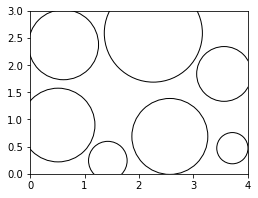

In [229]:
L=4
W=3
k=7
R=generator(k)  # randomly generate circle radius list; replace with given R
if check_valid(R, L, W):
    circleList=packing(R, L, W)
    plot(L,W, circleList)  # visualize the results
else:
    pass

## Results: 
it seems this method can solve the problem to some extent, but not very well. It can work fine for the cases when the circles are relatively sparse in the rectangle, which means the overlapping constraints are handled well. But when the circles are dense in the space (some cannot be hold in the rectangle), it cannot optimize well to discard some of the circles. As the binary constraints $p_i(1-p_i)=0$ for the objective seems cannot be solved well with off-the-shelf optimizer provided by Scipy, due to the highly non-convexity of the problem.

## The bonus part:
It can be solved with assigning a term for position of circles in the objective formula. Simply change the original objective to be $\min -\sum_i p_i\pi r_i^2+\lambda \sum_i((x_i-L/2)^2+(y_i-W/2)^2)$, where $\lambda$ is a positive tradeoff factor between two objectivs.